In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('dataSample1.csv')
df.head()

,Time,AC Power (kW),DC Power (kW),Cumulative AC Energy (kWh),Efficiency (%),DC Voltage (V),R PHASE Voltage (V),Y PHASE Voltage (V),B PHASE Voltage (V),DC Current (Amperes),...,Coil Temperature(° C),Ambient Temperature(° C),Today’s Energy(kWh),SMB1 Total Current(A),SMB2 Total Current(A),SMB3 Total Current(A),SMB4 Total Current(A),SMB5 Total Current(A),SMB6 Total Current(A),SMB7 Total Current(A)
0,01/02/2021 00:00,0.0,0.0,7486246,0.0,13,233.6,231.1,231.7,0.0,...,39.3,24.1,7010.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01/02/2021 00:01,0.0,0.0,7486246,0.0,13,233.8,231.3,231.9,0.0,...,39.2,24.1,7010.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01/02/2021 00:02,0.0,0.0,7486246,0.0,13,233.5,231.1,231.3,0.0,...,39.2,24.2,7010.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01/02/2021 00:03,0.0,0.0,7486246,0.0,13,233.5,231.1,231.3,0.0,...,39.2,24.2,7010.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01/02/2021 00:04,0.0,0.0,7486246,0.0,13,233.7,231.2,231.8,0.0,...,39.1,24.2,7010.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0


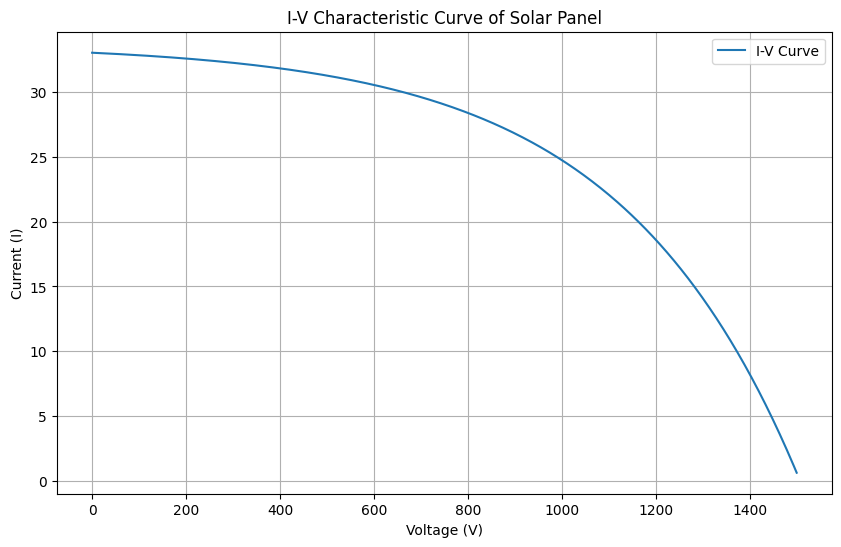

C1: 0.01976949241429257
C2: 0.2548669834555145


In [2]:
# Parameters
I_sc = 33.0  # Short-circuit current (A)
V_oc = 1500.0  # Open-circuit voltage (V)
I_m = 22.0  # Maximum current at MPP (A)
V_m = 1080.0  # Maximum voltage at MPP (V)

# Calculate C2
def calculate_C2(V_m, V_oc, I_m, I_sc):
    return (V_m / V_oc - 1) / np.log(1 - I_m / I_sc)

# Calculate C1
def calculate_C1(I_m, I_sc, V_m, V_oc, C2):
    return (1 - I_m / I_sc) * np.exp(-V_m / (C2 * V_oc))

# Calculate the current using the explicit model
def calculate_current(V, I_sc, V_oc, C1, C2):
    return I_sc * (1 - C1 * (np.exp(V / (C2 * V_oc)) - 1))

# Generate the C1 and C2 constants
C2 = calculate_C2(V_m, V_oc, I_m, I_sc)
C1 = calculate_C1(I_m, I_sc, V_m, V_oc, C2)

# Voltage range (from 0 to V_oc)
V_range = np.linspace(0, V_oc, 500)

# Calculate the current for each voltage in the range
I_values = calculate_current(V_range, I_sc, V_oc, C1, C2)

# Plot the I-V curve
plt.figure(figsize=(10, 6))
plt.plot(V_range, I_values, label="I-V Curve")
plt.title("I-V Characteristic Curve of Solar Panel")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (I)")
plt.grid(True)
plt.legend()
plt.show()

# Print C1 and C2 values for reference
print(f"C1: {C1}")
print(f"C2: {C2}")

Optimal Voltage (V): 705.00 V
Maximum Power (W): 20824.63 W


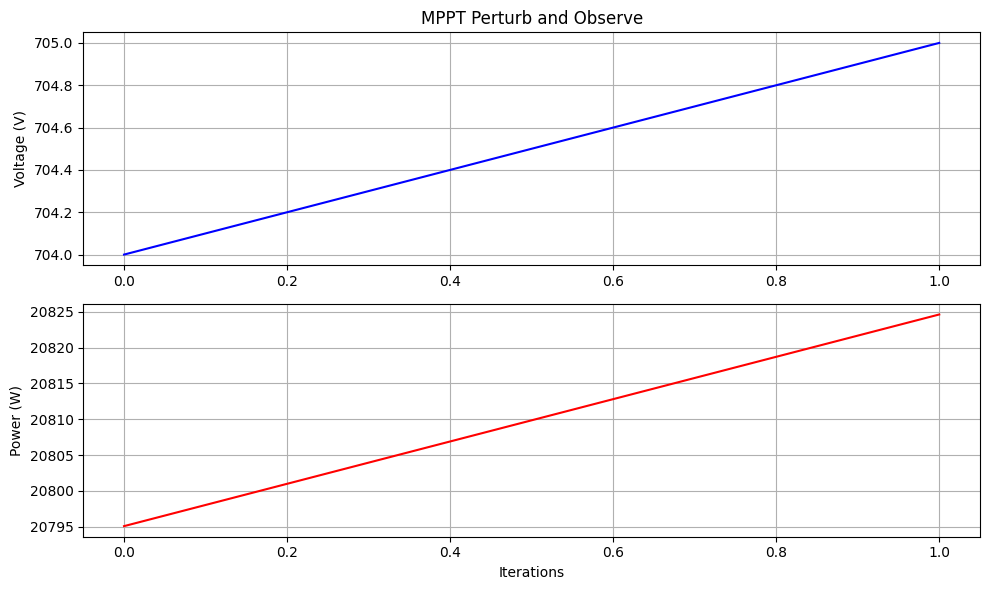

In [3]:
delta_v = 1.0  # Voltage perturbation step (Volts)
max_iterations = 100  # Maximum number of iterations for the MPPT algorithm

# Power calculation
def calculate_power(V, I):
    return V * I

# MPPT Perturb and Observe Algorithm
def mppt_perturb_and_observe(V_init, delta_v, max_iterations):
    # Initial values
    V_current = V_init
    I_current = calculate_current(V_current, I_sc, V_oc, C1, C2)
    P_current = calculate_power(V_current, I_current)
    
    V_optimal = V_current
    P_optimal = P_current
    
    voltage_track = [V_current]  # Track voltage changes
    power_track = [P_current]    # Track power changes
    
    # Perturb and Observe iterations
    for i in range(max_iterations):
        # Perturb the voltage
        V_new = V_current + delta_v
        I_new = calculate_current(V_current, I_sc, V_oc, C1, C2)
        P_new = calculate_power(V_new, I_new)
        
        # Compare new power with current power
        if P_new > P_current:
            # Power increased, continue in the same direction
            V_current = V_new
            P_current = P_new
        else:
            # Power decreased, reverse the perturbation direction
            delta_v = -delta_v
            V_current += delta_v  # Reverse direction
            
        # Track voltage and power
        voltage_track.append(V_current)
        power_track.append(P_current)
        
        # Update optimal values if necessary
        if P_current > P_optimal:
            V_optimal = V_current
            P_optimal = P_current
        
        # Break if the change in power is small (convergence)
        if abs(P_new - P_current) < 1e-3:
            break
    
    return V_optimal, P_optimal, voltage_track, power_track

# Run the MPPT simulation
V_init = 704  # Initial operating voltage (Volts)
V_optimal, P_optimal, voltage_track, power_track = mppt_perturb_and_observe(V_init, delta_v, max_iterations)

# Print the final optimal voltage and maximum power
print(f"Optimal Voltage (V): {V_optimal:.2f} V")
print(f"Maximum Power (W): {P_optimal:.2f} W")

# Plot the results
plt.figure(figsize=(10, 6))

# Voltage tracking
plt.subplot(2, 1, 1)
plt.plot(voltage_track, label="Voltage (Vdc)", color='blue')
plt.title("MPPT Perturb and Observe")
plt.ylabel("Voltage (V)")
plt.grid(True)

# Power tracking
plt.subplot(2, 1, 2)
plt.plot(power_track, label="Power (Pdc)", color='red')
plt.ylabel("Power (W)")
plt.xlabel("Iterations")
plt.grid(True)

plt.tight_layout()
plt.show()

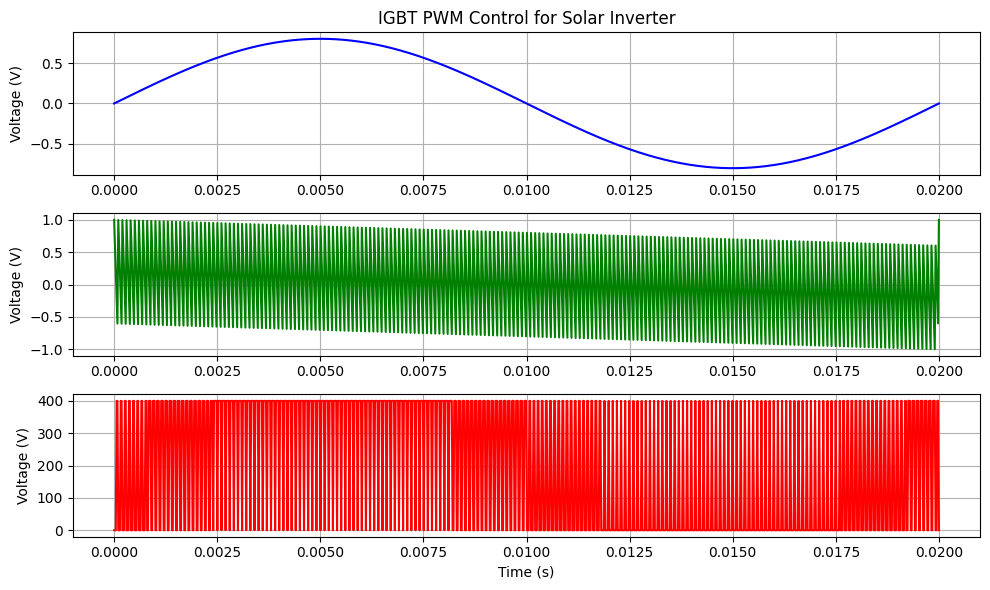

In [4]:
# Parameters
V_dc = 400  # Input DC voltage (V)
f_ac = 50  # AC output frequency (Hz)
f_pwm = 10000  # PWM frequency (Hz)
modulation_index = 0.8  # Modulation index

# Time array for one period of the AC output
t = np.linspace(0, 1/f_ac, 1000)

# Reference sinusoidal signal for AC output
V_ref = modulation_index * np.sin(2 * np.pi * f_ac * t)

# Carrier signal (triangular wave for PWM)
V_carrier = 1 * (1 - 2 * (t * f_pwm % 1))

# Generate PWM signal by comparing reference and carrier signals
PWM_signal = np.where(V_ref > V_carrier, 1, 0)

# Simulate output AC voltage (approximation using PWM signal)
V_ac_pwm = PWM_signal * V_dc

# Plot the results
plt.figure(figsize=(10, 6))

# Plot reference signal (AC sine wave)
plt.subplot(3, 1, 1)
plt.plot(t, V_ref, label="Reference AC Signal (V_ref)", color="blue")
plt.title("IGBT PWM Control for Solar Inverter")
plt.ylabel("Voltage (V)")
plt.grid(True)

# Plot carrier signal (PWM carrier wave)
plt.subplot(3, 1, 2)
plt.plot(t, V_carrier, label="Carrier Signal (V_carrier)", color="green")
plt.ylabel("Voltage (V)")
plt.grid(True)

# Plot PWM output (switching waveform)
plt.subplot(3, 1, 3)
plt.plot(t, V_ac_pwm, label="PWM Output (V_ac_pwm)", color="red")
plt.ylabel("Voltage (V)")
plt.xlabel("Time (s)")
plt.grid(True)

plt.tight_layout()
plt.show()


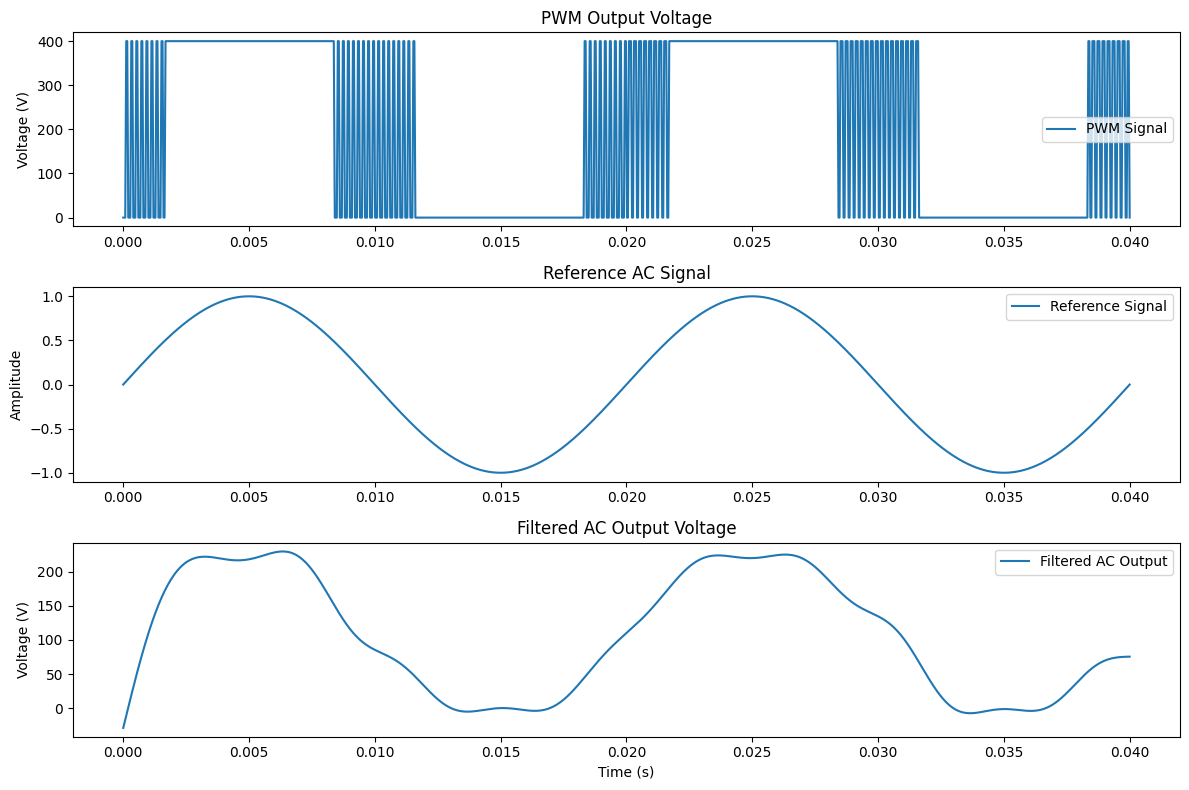

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Parameters
V_dc = 400  # DC input voltage in volts
I_dc = 100  # DC input current in amperes
efficiency = 0.98  # Efficiency of the inverter

# Calculate DC Power and AC Power
P_dc = V_dc * I_dc
P_ac = P_dc * efficiency

# Define time array
t = np.linspace(0, 0.04, 1000)  # 0.04 seconds, two cycles of 50 Hz

# PWM Parameters
f_pwm = 5000  # PWM frequency in Hz
f_ac = 50  # AC output frequency in Hz

# Generate carrier and reference signals
carrier = (np.sin(2 * np.pi * f_pwm * t) >= 0).astype(float)  # Square wave carrier
reference = np.sin(2 * np.pi * f_ac * t)  # Sinusoidal reference

# Generate PWM signal
pwm_signal = (reference > carrier - 0.5).astype(float)  # Simple comparator for PWM generation

# Calculate RMS Voltage Output
V_ac_rms = 230  # Assuming a power factor of 1

# Filter the PWM signal to get a sinusoidal waveform
def low_pass_filter(data, cutoff_hz, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff_hz / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

filtered_output = low_pass_filter(pwm_signal * V_dc, f_ac * 2, f_pwm * 2)
filtered_output *= (V_ac_rms / np.max(filtered_output))

# Plot the results
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.plot(t, pwm_signal * V_dc, label='PWM Signal')
plt.title('PWM Output Voltage')
plt.ylabel('Voltage (V)')
plt.legend()

plt.subplot(312)
plt.plot(t, reference, label='Reference Signal')
plt.title('Reference AC Signal')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(313)
plt.plot(t, filtered_output, label='Filtered AC Output')
plt.title('Filtered AC Output Voltage')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.legend()

plt.tight_layout()
plt.show()